Note only the first model is significant. The others are simply tests

In [12]:
!pip install torch torchvision
!pip install pytorch-lightning opencv-python-headless
!pip install tqdm


In [13]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose
from tqdm import tqdm

In [14]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

def convert_to_voc(xml_file, output_folder):
    
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Extract image metadata
    document_name = root.attrib['document']
    width, height = None, None
    
    for node in root.findall('Node'):
        box_id = node.find('Id').text
        label = node.find('ClassName').text
        xmin = int(node.find('Left').text)
        ymin = int(node.find('Top').text)
        xmax = xmin + int(node.find('Width').text)
        ymax = ymin + int(node.find('Height').text)
        
        # Create a Pascal VOC annotation file
        with open(os.path.join(output_folder, f"{document_name}_{box_id}.xml"), "w") as out_file:
            out_file.write(f"""<annotation>
    <folder>{output_folder}</folder>
    <filename>{document_name}.png</filename>
    <size>
        <width>{width}</width>
        <height>{height}</height>
        <depth>3</depth>
    </size>
    <object>
        <name>{label}</name>
        <bndbox>
            <xmin>{xmin}</xmin>
            <ymin>{ymin}</ymin>
            <xmax>{xmax}</xmax>
            <ymax>{ymax}</ymax>
        </bndbox>
    </object>
</annotation>""")
            


In [15]:
# base_dir = '/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/datasets/data/data/muscima_split'
# splits = ['/train/', '/test/', '/val/']
# for split in splits:
#     d = base_dir + split + 'annotations'
#     d2 = base_dir + split + 'annots2'
#     annotations = [f for f in os.listdir(d) if f.endswith(".xml")]
#     for f in annotations:
#         fname = d+ '/'+f
#         convert_to_voc(fname, d2)

In [16]:
# Dataset Class
class SheetMusicDataset(Dataset):
    def __init__(self, root_dir, CLASS_TO_IDX, transforms=None, resize_shape=(800, 800)):
        self.root_dir = root_dir
        self.annot_dir = os.path.join(root_dir, 'annots2')
        self.imgs_dir = os.path.join(root_dir, 'sheet_music')
        self.transforms = transforms
        self.resize = Resize(resize_shape)
        self.images = sorted([f for f in os.listdir(self.imgs_dir) if f.endswith(".png")])
        self.annotations = sorted([f for f in os.listdir(self.annot_dir) if f.endswith(".xml")])
        self.CLASS_TO_IDX = CLASS_TO_IDX

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.images[idx])
        annotation_path = os.path.join(self.annot_dir, self.annotations[idx])

        # Open image and get original size
        img = Image.open(img_path).convert("RGB")
        orig_size = img.size  # Original size (width, height)

        # Resize image
        img = self.resize(img)

        # Parse annotation
        target = parse_voc(annotation_path, orig_size=orig_size, CLASS_TO_IDX=self.CLASS_TO_IDX, new_size=self.resize.size)

        if self.transforms:
            img = self.transforms(img)
        # print(f"Image: {img.shape}, Target: {target}")  # Debugging output
        return img, target

    def __len__(self):
        return len(self.images)

def collate_fn(batch):
    return tuple(zip(*batch))

# Updated parse_voc Function
def parse_voc(xml_path, orig_size, CLASS_TO_IDX, new_size=(800, 800)):
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []
    scale_x = new_size[0] / orig_size[0]
    scale_y = new_size[1] / orig_size[1]

    for obj in root.findall("object"):
        label = obj.find("name").text
        if label in CLASS_TO_IDX:  # Ensure class is in the global list
            bbox = obj.find("bndbox")
            xmin = int(int(bbox.find("xmin").text) * scale_x)
            ymin = int(int(bbox.find("ymin").text) * scale_y)
            xmax = int(int(bbox.find("xmax").text) * scale_x)
            ymax = int(int(bbox.find("ymax").text) * scale_y)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(CLASS_TO_IDX[label])  # Use global index

    if not boxes:
        boxes = [[0, 0, 1, 1]]  # Add dummy box if none exist
        labels = [0]  # Background class

    target = {
        "boxes": torch.as_tensor(boxes, dtype=torch.float32),
        "labels": torch.as_tensor(labels, dtype=torch.int64)
    }
    return target



In [17]:
# Current working directory
cwd = os.getcwd()
print("Current Working Directory:", cwd)

# Base path
base_path = os.path.join(cwd, "datasets","data", "data", "muscima_split")
train_base = os.path.join(base_path, 'train')
val_base = os.path.join(base_path, 'val')
test_base = os.path.join(base_path, 'test')
# Correct paths for train, val, and test splits
train_xml_directory = os.path.join(base_path, "train", "annots2")
train_img_directory = os.path.join(base_path, "train", "sheet_music")
train_output_path = os.path.join(base_path, "train", "bounding_boxes.pkl")

val_xml_directory = os.path.join(base_path, "val", "annots2")
val_img_directory = os.path.join(base_path, "val", "sheet_music")
val_output_path = os.path.join(base_path, "val", "bounding_boxes.pkl")

test_xml_directory = os.path.join(base_path, "test", "annots2")
test_img_directory = os.path.join(base_path, "test", "sheet_music")
test_output_path = os.path.join(base_path, "test", "bounding_boxes.pkl")

json_path = os.path.join(cwd,'MUSCIMA_class_splits.json')

Current Working Directory: /Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer


In [18]:
import pickle
# Load bounding boxes
with open(train_output_path, 'rb') as f:
    train_bboxes = pickle.load(f)

with open(val_output_path, 'rb') as f:
    val_bboxes = pickle.load(f)

with open(test_output_path, 'rb') as f:
    test_bboxes = pickle.load(f)

# Extract the classes
def extract_classes_from_bboxes(bbox_dict):
    """
    Extract unique class labels from bounding box annotations.

    Args:
        bbox_dict (dict): Bounding box dictionary with filenames as keys and a list of bounding box annotations.

    Returns:
        list: Sorted list of unique class labels.
    """
    class_set = set()
    for filename, annotations in bbox_dict.items():
        if isinstance(annotations, list):
            for bbox in annotations:
                if isinstance(bbox, dict):
                    if 'className' in bbox:
                        class_set.add(bbox['className'])
                    elif 'label' in bbox:
                        class_set.add(bbox['label'])
                    else:
                        print(f"Warning: No 'class' or 'label' key found in bbox for {filename}: {bbox}")
                else:
                    print(f"Warning: Unexpected bbox format for {filename}: {bbox}")
        else:
            print(f"Warning: Unexpected annotations format for {filename}: {annotations}")
    return sorted(class_set)

trainclasses = extract_classes_from_bboxes(train_bboxes)
print("Training Extracted Classes:", trainclasses)
testclasses = extract_classes_from_bboxes(test_bboxes)
print("Testing Extracted Classes:", testclasses)
valclasses = extract_classes_from_bboxes(val_bboxes)
print("Val Extracted Classes:", valclasses)
print(len(trainclasses), len(testclasses), len(valclasses))

CLASS_NAMES = sorted(set(trainclasses + valclasses + testclasses))  # Merge and sort
print("All Classes:", CLASS_NAMES, '\n',len(CLASS_NAMES))
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
print("Class-to-Index Mapping:", CLASS_TO_IDX)

Training Extracted Classes: ['accidentalDoubleSharp', 'accidentalFlat', 'accidentalNatural', 'accidentalSharp', 'arpeggio', 'articulationAccent', 'articulationStaccato', 'articulationTenuto', 'augmentationDot', 'barline', 'barlineHeavy', 'beam', 'brace', 'bracket', 'breathMark', 'cClef', 'characterCapitalA', 'characterCapitalC', 'characterCapitalE', 'characterCapitalF', 'characterCapitalL', 'characterCapitalM', 'characterCapitalP', 'characterCapitalR', 'characterCapitalS', 'characterCapitalT', 'characterCapitalV', 'characterDot', 'characterOther', 'characterSmallA', 'characterSmallB', 'characterSmallC', 'characterSmallD', 'characterSmallE', 'characterSmallF', 'characterSmallG', 'characterSmallI', 'characterSmallJ', 'characterSmallL', 'characterSmallM', 'characterSmallN', 'characterSmallO', 'characterSmallP', 'characterSmallR', 'characterSmallS', 'characterSmallT', 'characterSmallU', 'characterSmallV', 'characterSmallX', 'characterSmallZ', 'dottedHorizontalSpanner', 'dynamicCrescendoHai

In [19]:
from collections import Counter

def count_classes(annotation_dir):
    class_counter = Counter()
    for file in os.listdir(annotation_dir):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(annotation_dir, file))
            root = tree.getroot()
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                class_counter[class_name] += 1
    return class_counter

train_class_counts = count_classes(train_xml_directory)
val_class_counts = count_classes(val_xml_directory)

print("Training Class Counts:", train_class_counts)
print("Validation Class Counts:", val_class_counts)


Training Class Counts: Counter({'noteheadFull': 17244, 'stem': 17180, 'legerLine': 5591, 'beam': 5279, 'staffSpace': 4236, 'staffLine': 3530, 'barline': 2762, 'measureSeparator': 2365, 'slur': 2115, 'augmentationDot': 1656, 'accidentalSharp': 1652, 'noteheadHalf': 1226, 'articulationStaccato': 1196, 'rest8th': 981, 'accidentalFlat': 953, 'accidentalNatural': 930, 'flag8thDown': 925, 'flag8thUp': 891, 'staff': 706, 'restQuarter': 605, 'dynamicsText': 595, 'tie': 568, 'keySignature': 565, 'dynamicLetterF': 448, 'characterSmallP': 444, 'characterSmallF': 444, 'rest16th': 426, 'characterSmallE': 367, 'dynamicLetterP': 361, 'characterSmallR': 332, 'gClef': 303, 'noteheadFullSmall': 297, 'characterSmallO': 293, 'characterSmallS': 285, 'numeral3': 272, 'characterSmallT': 234, 'flag16thUp': 232, 'fClef': 229, 'dynamicDiminuendoHairpin': 224, 'otherText': 219, 'tuple': 204, 'characterSmallC': 198, 'repeatDot': 194, 'dynamicCrescendoHairpin': 193, 'flag16thDown': 192, 'restHalf': 170, 'cClef': 1

Epoch 1/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 1/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 1, Training Loss: 0.7547, Validation Loss: 1.1893
Best model saved with validation loss: 1.1893


Epoch 2/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 2/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 2, Training Loss: 0.6115, Validation Loss: 0.7588
Best model saved with validation loss: 0.7588


Epoch 3/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 3/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 3, Training Loss: 0.5732, Validation Loss: 0.7614


Epoch 4/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 4/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 4, Training Loss: 0.5203, Validation Loss: 1.0038


Epoch 5/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 5/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 5, Training Loss: 0.5075, Validation Loss: 1.0867


Epoch 6/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 6/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 6, Training Loss: 0.5000, Validation Loss: 2.8182


Epoch 7/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 7/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 7, Training Loss: 0.6151, Validation Loss: 0.6576
Best model saved with validation loss: 0.6576


Epoch 8/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 8/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 8, Training Loss: 0.5799, Validation Loss: 0.7762


Epoch 9/10 [Training]:   0%|                                              | 0/57 [00:00<?, ?batch/s]

Epoch 9/10 [Validation]:   0%|                                             | 0/7 [00:00<?, ?batch/s]

Epoch 9, Training Loss: 0.5389, Validation Loss: 0.7846


Epoch 10/10 [Training]:   0%|                                             | 0/57 [00:00<?, ?batch/s]

Epoch 10/10 [Validation]:   0%|                                            | 0/7 [00:00<?, ?batch/s]

Epoch 10, Training Loss: 0.4961, Validation Loss: 0.8808
Training and validation losses saved to 'train_losses.json' and 'val_losses.json'


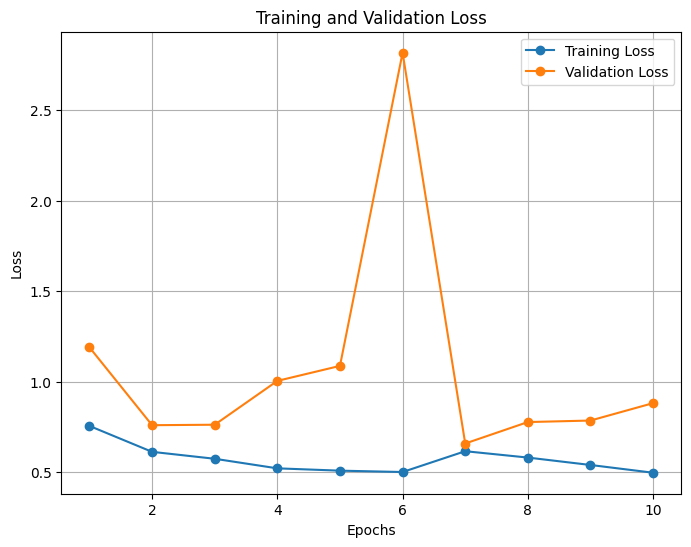

In [ ]:
import json
from tqdm.notebook import tqdm
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Resize, ToTensor, Compose
import matplotlib.pyplot as plt

# Custom collate_fn for Faster R-CNN
def collate_fn(batch):
    return tuple(zip(*batch))

# Split Dataset into Train and Validation
transforms = Compose([Resize((800, 800)), ToTensor()])

train_dataset = SheetMusicDataset(
    root_dir=train_base, transforms=transforms, CLASS_TO_IDX=CLASS_TO_IDX
)
val_dataset = SheetMusicDataset(
    root_dir=val_base, transforms=transforms, CLASS_TO_IDX=CLASS_TO_IDX
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)

# Model Setup
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
num_classes = len(CLASS_NAMES)  # Includes background
model.roi_heads.box_predictor.cls_score.out_features = num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer and Hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

# Track losses and best model
train_losses = {}
val_losses = {}
best_loss = float("inf")
best_model_path = "/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/best_model.pth"

# Training Loop with Validation
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", unit="batch", ncols=100)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses[f"Epoch {epoch+1}"] = avg_train_loss

    # Validation Step
    total_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        model.train()  # Temporarily switch to training mode to compute loss
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", unit="batch", ncols=100)
        for images, targets in val_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Compute the loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_val_loss += losses.item()
            val_bar.set_postfix(loss=losses.item())
        model.eval()  # Switch back to evaluation mode


    avg_val_loss = total_val_loss / len(val_loader)
    val_losses[f"Epoch {epoch+1}"] = avg_val_loss

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the best model based on validation loss
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_loss:.4f}")

# Save losses to JSON
with open("train_losses.json", "w") as json_file:
    json.dump(train_losses, json_file, indent=4)
with open("val_losses.json", "w") as json_file:
    json.dump(val_losses, json_file, indent=4)

print("Training and validation losses saved to 'train_losses.json' and 'val_losses.json'")

# Plot Train and Validation Losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses.values(), label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses.values(), label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}


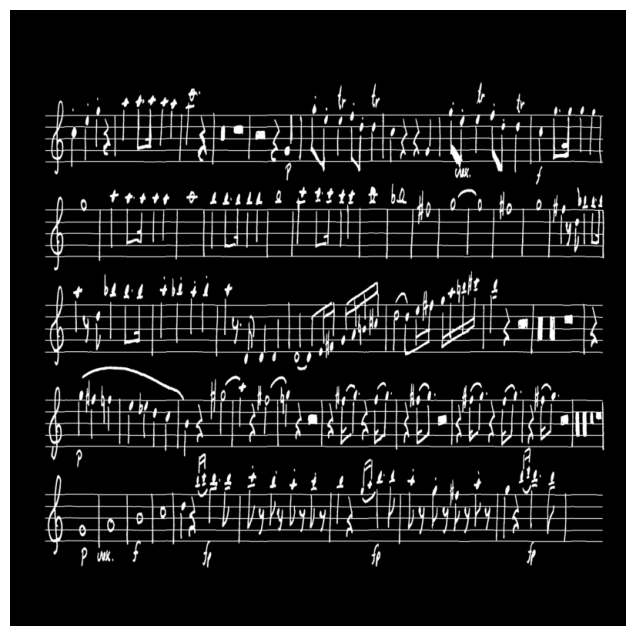

{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}


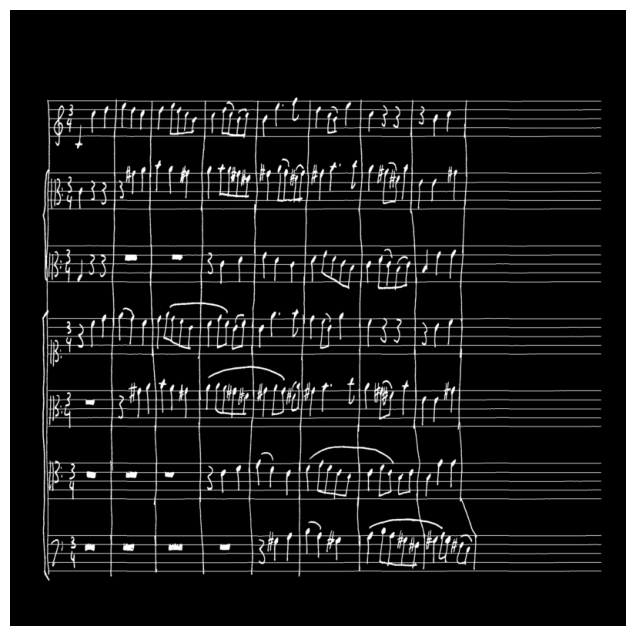

{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}


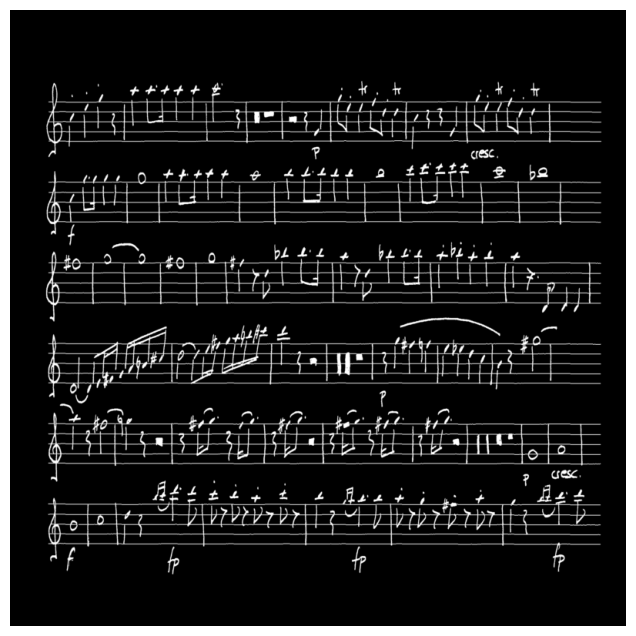

{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}


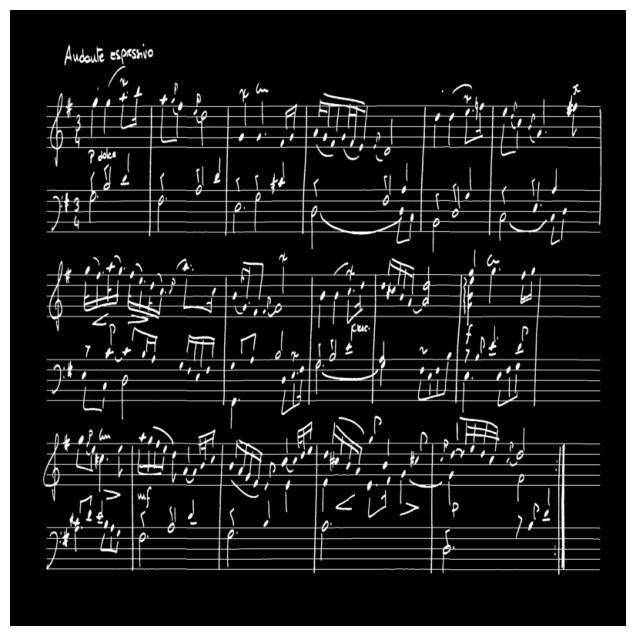

In [25]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from PIL import Image, ImageDraw, ImageFont


# Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(weights=None)  # Initialize without pretrained weights
model.roi_heads.box_predictor.cls_score.out_features = len(CLASS_NAMES)  # Set correct number of classes
model.load_state_dict(torch.load("best_model.pth"))  # Load trained model
model.to(device)
model.eval()

# Evaluation Dataset
transforms = ToTensor()  # Convert images to tensors
test_dataset = SheetMusicDataset(
    root_dir=test_base, transforms=transforms, CLASS_TO_IDX=CLASS_TO_IDX
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Function to Draw Bounding Boxes
def draw_boxes(image, predictions, threshold=0.5):
    """
    Draws bounding boxes and labels on an image based on predictions.
    Args:
        image (PIL.Image): Input image.
        predictions (dict): Dictionary containing predicted boxes, labels, and scores.
        threshold (float): Confidence threshold to filter predictions.
    """
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:  # Only draw boxes above confidence threshold
            x1, y1, x2, y2 = box
            class_name = CLASS_NAMES[label]
            color = "red"

            # Draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)

            # Draw label and confidence
            text = f"{class_name}: {score:.2f}"
            text_size = font.getsize(text)
            draw.rectangle([x1, y1, x1 + text_size[0] + 5, y1 + text_size[1] + 5], fill=color)
            draw.text((x1 + 2, y1 + 2), text, fill="white", font=font)

    return image

# Evaluation and Visualization (Show Only 4 Images)
image_count = 0
for images, targets in test_loader:
    if image_count >= 4:  # Stop after showing 4 images
        break

    # Move images to device
    images = [img.to(device) for img in images]
    
    # Get model predictions
    with torch.no_grad():
        predictions = model(images)

    # Convert predictions to CPU and process
    for img, pred in zip(images, predictions):
        print(pred)
        img = img.mul(255).permute(1, 2, 0).byte().cpu().numpy()  # Convert tensor to PIL-compatible format
        img_pil = Image.fromarray(img)

        # Convert predictions to CPU for processing
        pred_boxes = pred['boxes'].cpu().numpy()
        pred_labels = pred['labels'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()

        # Prepare predictions dictionary
        predictions_dict = {
            "boxes": pred_boxes,
            "labels": pred_labels,
            "scores": pred_scores
        }

        # Draw bounding boxes and labels
        img_with_boxes = draw_boxes(img_pil, predictions_dict, threshold=0.5)

        # Display the image
        plt.figure(figsize=(8, 8))
        plt.imshow(img_with_boxes)
        plt.axis("off")
        plt.show()

        image_count += 1
        if image_count >= 4:  # Stop after showing 4 images
            break


Training Extracted Classes: ['accidentalDoubleSharp', 'accidentalFlat', 'accidentalNatural', 'accidentalSharp', 'arpeggio', 'articulationAccent', 'articulationStaccato', 'articulationTenuto', 'augmentationDot', 'barline', 'barlineHeavy', 'beam', 'brace', 'bracket', 'breathMark', 'cClef', 'characterCapitalA', 'characterCapitalC', 'characterCapitalE', 'characterCapitalF', 'characterCapitalL', 'characterCapitalM', 'characterCapitalP', 'characterCapitalR', 'characterCapitalS', 'characterCapitalT', 'characterCapitalV', 'characterDot', 'characterOther', 'characterSmallA', 'characterSmallB', 'characterSmallC', 'characterSmallD', 'characterSmallE', 'characterSmallF', 'characterSmallG', 'characterSmallI', 'characterSmallJ', 'characterSmallL', 'characterSmallM', 'characterSmallN', 'characterSmallO', 'characterSmallP', 'characterSmallR', 'characterSmallS', 'characterSmallT', 'characterSmallU', 'characterSmallV', 'characterSmallX', 'characterSmallZ', 'dottedHorizontalSpanner', 'dynamicCrescendoHai

Epoch 1/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 1/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1: Train Loss: 0.7201, Val Loss: 1.3302
Best model saved at epoch 1 with Val Loss: 1.3302


Epoch 2/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 2/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 2: Train Loss: 0.5883, Val Loss: 0.7465
Best model saved at epoch 2 with Val Loss: 0.7465


Epoch 3/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 3/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 3: Train Loss: 0.5415, Val Loss: 0.8838


Epoch 4/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 4/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 4: Train Loss: 0.4805, Val Loss: 25.7772


Epoch 5/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 5/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 5: Train Loss: 0.5134, Val Loss: 4.0733


Epoch 6/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 6/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 6: Train Loss: 0.4657, Val Loss: 6.6798


Epoch 7/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 7/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 7: Train Loss: 0.4229, Val Loss: 11.2206


Epoch 8/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 8/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 8: Train Loss: 0.4912, Val Loss: 0.8748


Epoch 9/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 9/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 9: Train Loss: 0.4401, Val Loss: 3.6264


Epoch 10/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 10/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 10: Train Loss: 0.4029, Val Loss: 4.4309


Epoch 11/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 11/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 11: Train Loss: 0.3798, Val Loss: 4.6194


Epoch 12/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 12/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 12: Train Loss: 0.3620, Val Loss: 4.9412


Epoch 13/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 13/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 13: Train Loss: 0.3476, Val Loss: 5.2109


Epoch 14/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 14/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 14: Train Loss: 0.3257, Val Loss: 5.8707


Epoch 15/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 15/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 15: Train Loss: 0.2878, Val Loss: 6.6132


Epoch 16/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 16/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 16: Train Loss: 0.2774, Val Loss: 6.9906


Epoch 17/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 17/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 17: Train Loss: 0.2600, Val Loss: 7.4959


Epoch 18/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 18/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 18: Train Loss: 0.2512, Val Loss: 7.8585


Epoch 19/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 19/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 19: Train Loss: 0.2287, Val Loss: 8.3751


Epoch 20/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 20/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 20: Train Loss: 0.2194, Val Loss: 8.7274


Epoch 21/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 21/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 21: Train Loss: 0.2095, Val Loss: 8.9721


Epoch 22/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 22/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 22: Train Loss: 0.1962, Val Loss: 9.3628


Epoch 23/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 23/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 23: Train Loss: 0.1826, Val Loss: 9.6004


Epoch 24/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 24/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 24: Train Loss: 0.1794, Val Loss: 9.8260


Epoch 25/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 25/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 25: Train Loss: 0.1767, Val Loss: 9.9333


Epoch 26/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 26/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 26: Train Loss: 0.1715, Val Loss: 10.0832


Epoch 27/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 27/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 27: Train Loss: 0.1633, Val Loss: 10.1977


Epoch 28/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 28/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 28: Train Loss: 0.1607, Val Loss: 10.2868


Epoch 29/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 29/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 29: Train Loss: 0.1577, Val Loss: 10.4155


Epoch 30/30 [Training]:   0%|          | 0/57 [00:00<?, ?batch/s]

Epoch 30/30 [Validation]:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 30: Train Loss: 0.1598, Val Loss: 10.4883


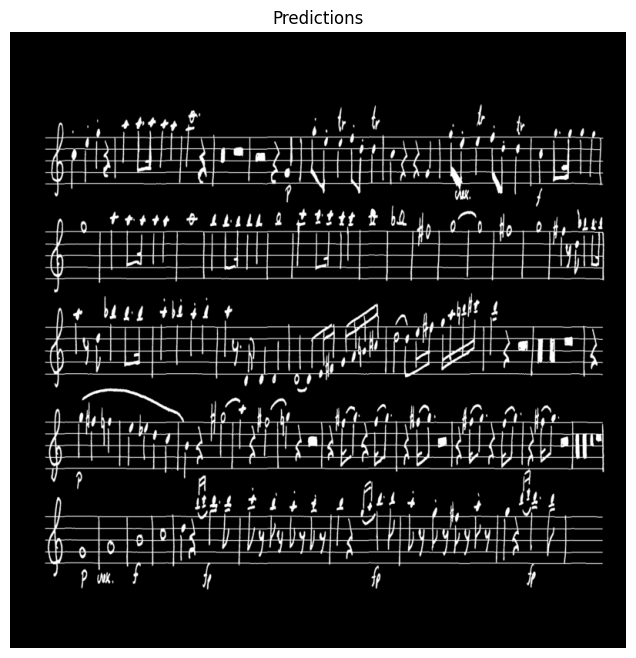

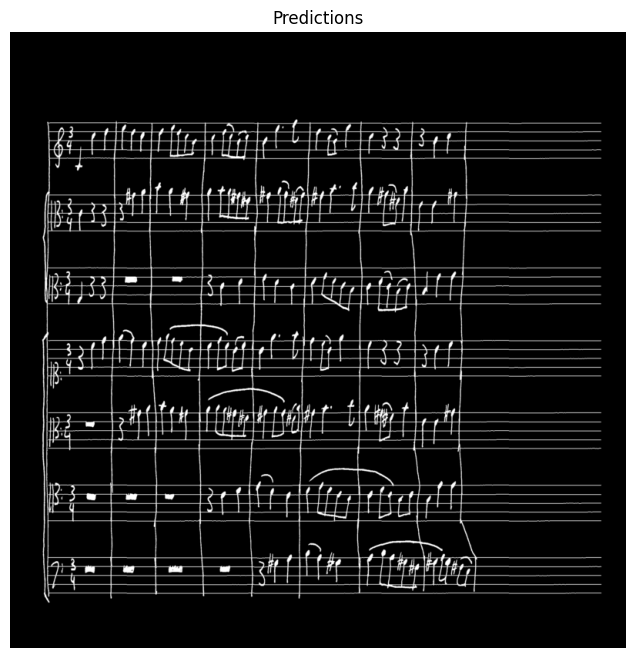

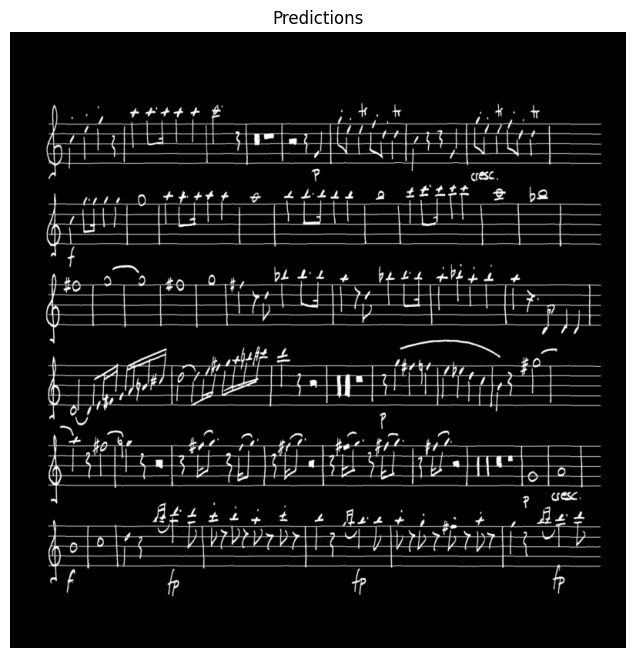

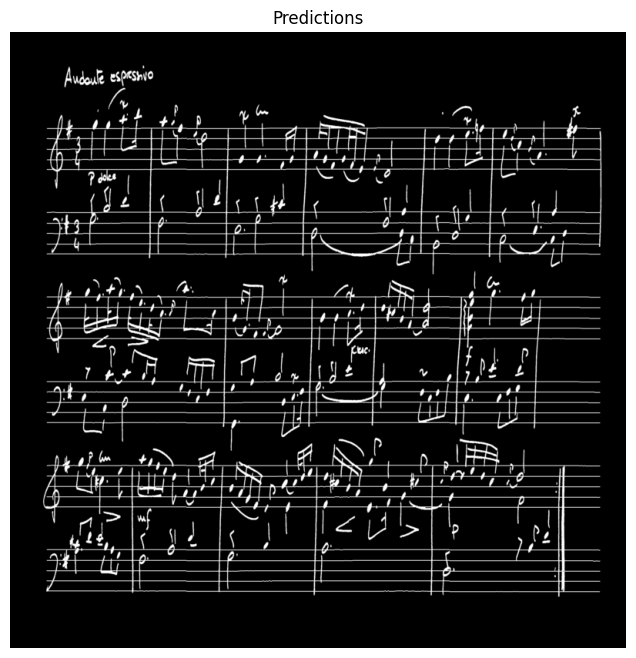

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.transforms import ToTensor, Resize, Compose, RandomHorizontalFlip, ColorJitter
from PIL import Image, ImageDraw, ImageFont
import json
from tqdm.notebook import tqdm


import pickle
# Load bounding boxes
with open(train_output_path, 'rb') as f:
    train_bboxes = pickle.load(f)

with open(val_output_path, 'rb') as f:
    val_bboxes = pickle.load(f)

with open(test_output_path, 'rb') as f:
    test_bboxes = pickle.load(f)

# Extract the classes
def extract_classes_from_bboxes(bbox_dict):
    """
    Extract unique class labels from bounding box annotations.

    Args:
        bbox_dict (dict): Bounding box dictionary with filenames as keys and a list of bounding box annotations.

    Returns:
        list: Sorted list of unique class labels.
    """
    class_set = set()
    for filename, annotations in bbox_dict.items():
        if isinstance(annotations, list):
            for bbox in annotations:
                if isinstance(bbox, dict):
                    if 'className' in bbox:
                        class_set.add(bbox['className'])
                    elif 'label' in bbox:
                        class_set.add(bbox['label'])
                    else:
                        print(f"Warning: No 'class' or 'label' key found in bbox for {filename}: {bbox}")
                else:
                    print(f"Warning: Unexpected bbox format for {filename}: {bbox}")
        else:
            print(f"Warning: Unexpected annotations format for {filename}: {annotations}")
    return sorted(class_set)

trainclasses = extract_classes_from_bboxes(train_bboxes)
print("Training Extracted Classes:", trainclasses)
testclasses = extract_classes_from_bboxes(test_bboxes)
print("Testing Extracted Classes:", testclasses)
valclasses = extract_classes_from_bboxes(val_bboxes)
print("Val Extracted Classes:", valclasses)
print(len(trainclasses), len(testclasses), len(valclasses))

CLASS_NAMES = sorted(set(trainclasses + valclasses + testclasses))  # Merge and sort
print("All Classes:", CLASS_NAMES, '\n',len(CLASS_NAMES))
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
print("Class-to-Index Mapping:", CLASS_TO_IDX)

# ------------------ CONFIGURATION ------------------ #
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 30
BATCH_SIZE = 2
LEARNING_RATE = 1e-4
OVERFIT_SMALL_DATASET = False  # Debug mode: train on small dataset to test pipeline
CLASS_NAMES = ["background", "noteheadFull", "noteheadEmpty", "restSymbol", "clef", "barline"]

# ------------------ DATASET SETUP ------------------ #
# Custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Data augmentation for training
train_transforms = Compose([
    Resize((800, 800)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ToTensor()
])
val_transforms = Compose([Resize((800, 800)), ToTensor()])

# Create datasets
train_dataset = SheetMusicDataset(
    root_dir=train_base, transforms=transforms, CLASS_TO_IDX=CLASS_TO_IDX
)
val_dataset = SheetMusicDataset(
    root_dir=val_base, transforms=transforms, CLASS_TO_IDX=CLASS_TO_IDX
)

# Optional: Subset the dataset for debugging
if OVERFIT_SMALL_DATASET:
    train_dataset = Subset(train_dataset, range(10))
    val_dataset = Subset(val_dataset, range(10))

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# ------------------ MODEL SETUP ------------------ #
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn(weights=weights)
model.roi_heads.box_predictor.cls_score.out_features = len(CLASS_NAMES)  # Adjust for custom classes
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# Loss tracking
train_losses, val_losses = {}, {}
best_val_loss = float("inf")
best_model_path = "best_model.pth"

# ------------------ TRAINING LOOP ------------------ #
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", unit="batch")
    for images, targets in progress_bar:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses[epoch+1] = avg_train_loss

    # Validation Step
    model.eval()  # Ensure evaluation mode for consistency
    total_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        model.train()  # Temporarily switch to training mode to compute losses
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", unit="batch")
        for images, targets in val_bar:
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            # Compute the loss
            loss_dict = model(images, targets)  # Loss computation requires train() mode
            loss = sum(loss for loss in loss_dict.values())

            total_val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
        model.eval()  # Switch back to evaluation mode

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses[epoch+1] = avg_val_loss

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with Val Loss: {best_val_loss:.4f}")

    # Update the scheduler
    scheduler.step(avg_val_loss)

# Save losses to JSON
with open("train_losses.json", "w") as f:
    json.dump(train_losses, f, indent=4)
with open("val_losses.json", "w") as f:
    json.dump(val_losses, f, indent=4)




In [34]:
from torchsummary import summary 
summary(model, (1, 800, 800))

AttributeError: 'ImageList' object has no attribute 'size'

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


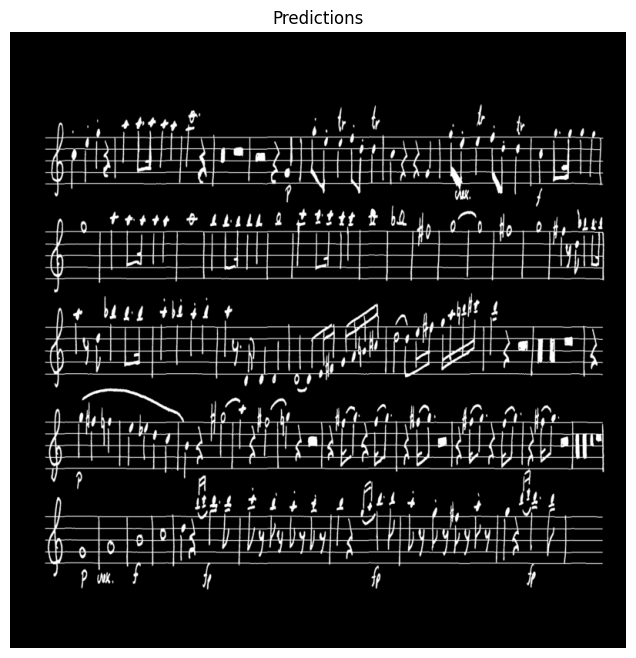

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


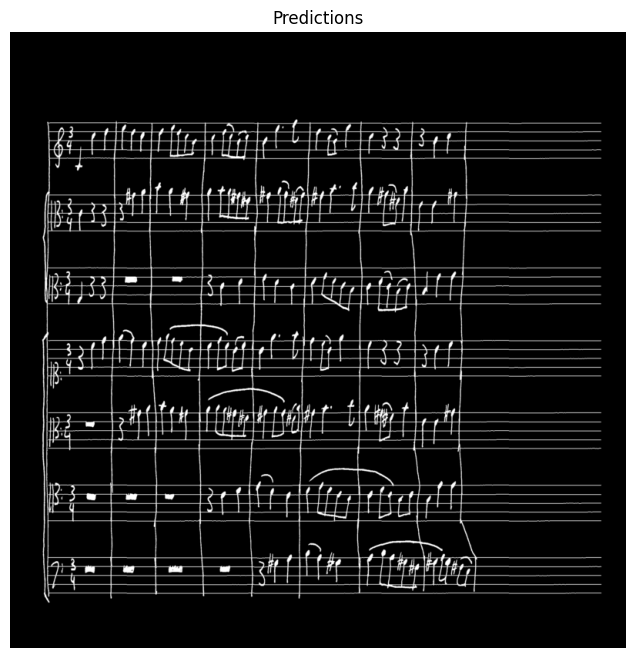

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


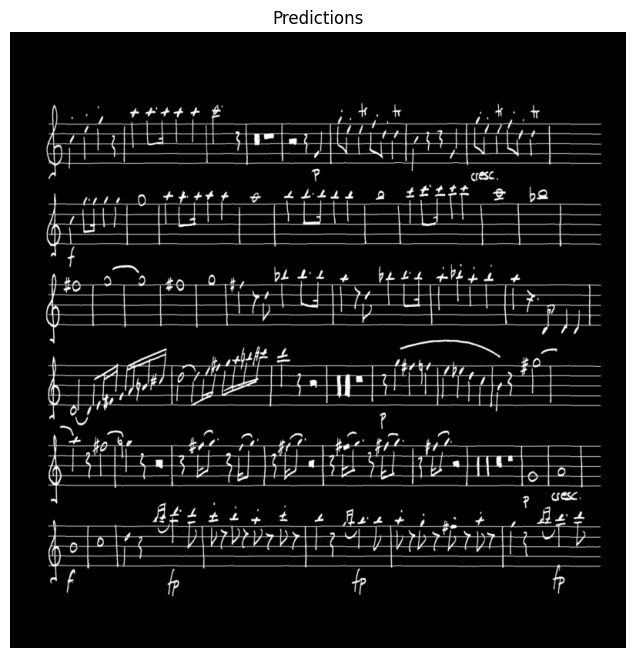

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


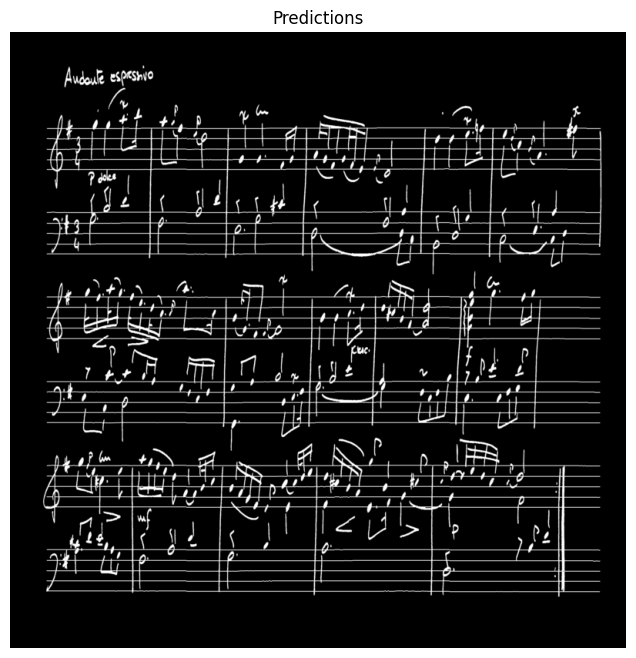

In [29]:
# ------------------ EVALUATION AND VISUALIZATION ------------------ #
def visualize_predictions(dataset, model, threshold=0.5, num_images=4):
    model.eval()
    font = ImageFont.load_default()
    count = 0

    for images, targets in DataLoader(dataset, batch_size=1, collate_fn=collate_fn):
        if count >= num_images:
            break

        images = [img.to(DEVICE) for img in images]
        with torch.no_grad():
            predictions = model(images)
            print(predictions)

        img = images[0].mul(255).permute(1, 2, 0).byte().cpu().numpy()
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)

        for box, label, score in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
            if score > threshold:
                box = box.cpu().numpy()
                label = CLASS_NAMES[label]
                draw.rectangle(box, outline="red", width=3)
                draw.text((box[0], box[1]), f"{label}: {score:.2f}", fill="white", font=font)

        plt.figure(figsize=(8, 8))
        plt.imshow(img_pil)
        plt.title(f"Predictions")
        plt.axis("off")
        plt.show()

        count += 1

best_model_path = "/Users/costanzasiniscalchi/Documents/MS/DLCV/Sheet-Music-Parser/ModelTrainer/models/model_pths/best_model.pth"

# Visualize model predictions
model.load_state_dict(torch.load(best_model_path))
test_dataset = SheetMusicDataset(
    root_dir=test_base, transforms=transforms, CLASS_TO_IDX=CLASS_TO_IDX
)
visualize_predictions(test_dataset, model, threshold=0.5, num_images=4)

In [ ]:
t